
#LOW-LIGHT + NUCLEAR NORM

## Oscar Miguel Ortega Lozano - 2220528


## Daniel Esteban Yaruro Contreras - 2220088


## Juan David Toloza Parada - 2221136

# **Imagen en Condiciones de Baja Iluminación (Low-Light)**

Se presenta una implementación del algoritmo **ADMM (Alternating Direction Method of Multipliers)** para resolver un problema de mejora de imagen en condiciones de **baja iluminación**. Se modela el ruido como una distribución de **Poisson**, y se usa la **norma nuclear** como prior para regularización.

<br>

## **Formulación del problema**

Dado:
- Imagen observada $y$ con ruido tipo Poisson.
- Imagen original desconocida $x$.

Modelo probabilístico:
$$
y \sim \mathcal{P}(yx)
$$

Función objetivo:
$$
\min_x \quad y^T \cdot \mathbf{1} - y^T \log(yx) + \lambda \|x\|_*
$$

Donde:
- $\|x\|_*$ es la **norma nuclear** (suma de valores singulares de $x$).
- $\lambda$ es un parámetro que controla la regularización.

<br>

## **Algoritmo ADMM**

Reformulamos con una variable auxiliar $z$:
$$
\min_{x, z} \quad f(x) + g(z) \quad \text{sujeto a } x = z
$$
Donde:
- $f(x) = y^T \cdot \mathbf{1} - y^T \log(x)$ (ya que $y$ es fija)
- $g(z) = \lambda \|z\|_*$

<br>

Inicializamos $x^0, z^0, u^0$ y luego iteramos:

<br>

### **Actualización de $x$**


$$
x^{k+1} = \arg\min_x \left[ f(x) + \frac{\rho}{2} \|x - z^k + u^k\|_2^2 \right]
$$

<br>

$$
x^{k+1} = \arg\min_x \left[ -y^T \log(x) + \frac{\rho}{2} \|x - z^k + u^k\|_2^2 \right]
$$

<br>


#### Derivada del término de Poisson:


$$
\nabla_x \left( -\sum_i y_i \log(x_i) \right) = -\frac{y}{x}
$$


$$
\nabla_x = -\frac{y}{x} + \rho(x - z^k + u^k)
$$

<br>

Se utiliza este gradiente en un esquema de descenso de gradiente:

<br>

$$
x^{k+1} = x^k - \alpha \left( -\frac{y}{x^k} + \rho(x^k - z^k + u^k) \right)
$$

<br>

### **Actualización de $z$**

$$
z^{k+1} = \arg\min_z \left[ g(z) + \frac{\rho}{2} \|x^{k+1} - z + u^k\|_2^2 \right]
$$

<br>

$$
z^{k+1} = \arg\min_z \left[ \lambda \|z\|_* + \frac{\rho}{2} \|x^{k+1} - z + u^k\|_2^2 \right]
$$

<br>

**Operador proximal de la norma nuclear**:
$$
z = \text{prox}_{\lambda/\rho}(x + u) = U \cdot \text{soft}(\Sigma, \lambda/\rho) \cdot V^T
$$

Donde:
- $x + u = U \Sigma V^T$ es la descomposición SVD.
- $\text{soft}(\Sigma, t) = \max(\Sigma - t, 0)$

<br>

### **Actualización del dual $u$**

$$
u^{k+1} = u^k + x^{k+1} - z^{k+1}
$$

<br>

### **Observaciones**

Se espera que la imagen restaurada atenúe el ruido propio de condiciones de baja iluminación, mantenga la estructura general de la escena y que sea más suave, aunque mucho más brillante, esto gracias a que la **norma nuclear** tiende a producir soluciones de bajo rango.




In [59]:
#@title Librerias
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from google.colab import drive
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/UIS/7_semestre/Procesamiento_de_imagenes_digitales/Images/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/UIS/7_semestre/Procesamiento_de_imagenes_digitales/Images


In [68]:
#@title Funciones

# Soft-thresholding para norma nuclear
def prox_nuclear(X, tau):
  U, S, Vt = np.linalg.svd(X, full_matrices=False)
  S_thresh = np.maximum(S - tau, 0)
  return U @ np.diag(S_thresh) @ Vt

# Derivada del término Poisson
def grad_poisson(x, y):
  return -y / np.maximum(x, 1e-4)

# ADMM
def admm_poisson_nuclear(Y, lambd=0.1, rho=1.0, max_iter=100, step_size=0.1):
  X = np.copy(Y)
  Z = np.copy(Y)
  U = np.zeros_like(Y)

  for i in range(max_iter):

    grad = grad_poisson(X, Y)

    X = X - step_size * (grad + rho * (X - Z + U))

    Z = prox_nuclear(X + U, lambd / rho)

    U = U + X - Z

  return Z

# Plotear imagenes
def ploteo(imagen,Y,Z):
  plt.figure(figsize=(12, 4))
  plt.subplot(131), plt.imshow(imagen, cmap='gray'), plt.title('Original'), plt.axis('off')
  plt.subplot(132), plt.imshow(Y, cmap='gray'), plt.title('Noisy (Low-Light)'), plt.axis('off')
  plt.subplot(133), plt.imshow(Z, cmap='gray'), plt.title('Restored (ADMM)'), plt.axis('off')
  plt.tight_layout()
  plt.show()


In [66]:
#@title Probando con dos imagenes
img1 = cv2.resize(cv2.imread('sudoku.png', cv2.IMREAD_GRAYSCALE), (256, 256))
img1 = img1.astype(np.float32) / 255.0

img2 = cv2.resize(cv2.imread('xray_circuit.tif', cv2.IMREAD_GRAYSCALE), (256, 256))
img2 = img2.astype(np.float32) / 255.0


#Agregando ruido
peak = 30
Y1 = np.random.poisson(img1 * peak) / peak
Y1 = np.clip(Y1, 1e-4, 1.0)  # evitamos log(0)

peak = 10
Y2 = np.random.poisson(img2 * peak) / peak
Y2 = np.clip(Y2, 1e-4, 1.0)



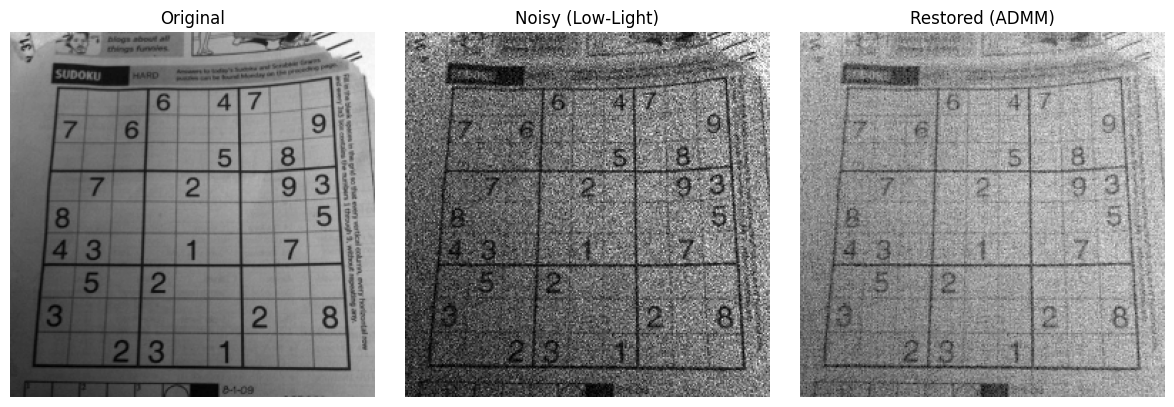

In [69]:
#@title Imagen 1
restored1 = admm_poisson_nuclear(Y1, lambd=0.5, rho=5.0, max_iter=200, step_size=0.05)
ploteo(img1,Y1,restored1)

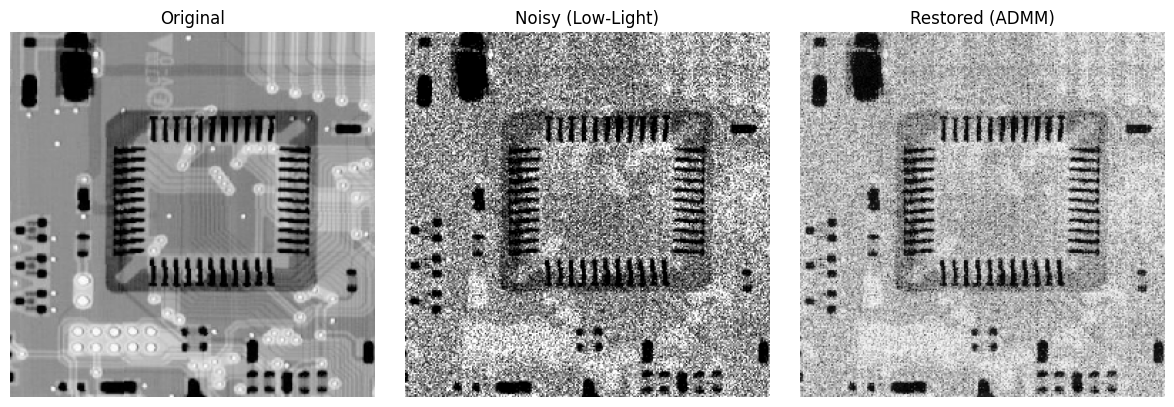

In [70]:
#@title Imagen 2
restored2 = admm_poisson_nuclear(Y2, lambd=0.5, rho=5.0, max_iter=200, step_size=0.05)
ploteo(img2,Y2,restored2)

---

### 6. Métricas de Evaluación

Para evaluar la calidad de la restauración de la imagen, se utilizan las siguientes métricas:

#### a) PSNR (Peak Signal-to-Noise Ratio)

Mide la relación entre la potencia máxima de la señal y el ruido que afecta a su representación. Una mayor PSNR indica mejor calidad.

$$
\text{PSNR} = 10 \cdot \log_{10} \left( \frac{MAX_I^2}{\text{MSE}} \right)
$$

Donde:
- $MAX_I$ es el valor máximo posible de un píxel (255 para imágenes de 8 bits).
- MSE es el error cuadrático medio entre la imagen original $x$ y la restaurada $\hat{x}$:
$$
\text{MSE} = \frac{1}{mn} \sum_{i=1}^{m} \sum_{j=1}^{n} \left( x_{ij} - \hat{x}_{ij} \right)^2
$$

#### b) SSIM (Structural Similarity Index)

Mide la similitud estructural entre dos imágenes considerando luminancia, contraste y estructura.

$$
\text{SSIM}(x, \hat{x}) = \frac{(2\mu_x\mu_{\hat{x}} + C_1)(2\sigma_{x\hat{x}} + C_2)}{(\mu_x^2 + \mu_{\hat{x}}^2 + C_1)(\sigma_x^2 + \sigma_{\hat{x}}^2 + C_2)}
$$

Donde:
- $\mu_x$, $\mu_{\hat{x}}$ son las medias locales.
- $\sigma_x^2$, $\sigma_{\hat{x}}^2$ son las varianzas.
- $\sigma_{x\hat{x}}$ es la covarianza entre $x$ y $\hat{x}$.

Valores de SSIM cercanos a 1 indican alta similitud.

#### c) RMSE (Root Mean Square Error)

Mide el error promedio entre la imagen original y la restaurada:

$$
\text{RMSE} = \sqrt{ \frac{1}{mn} \sum_{i=1}^{m} \sum_{j=1}^{n} \left( x_{ij} - \hat{x}_{ij} \right)^2 }
$$

Un valor más bajo de RMSE indica menor error de restauración.

---

Estas métricas permiten comparar objetivamente el desempeño del algoritmo de restauración ADMM en presencia de ruido tipo Poisson bajo condiciones de baja iluminación.


In [4]:


# Función para calcular las métricas
def compute_metrics(original, noisy, restored):
    # Asegúrate de que todo esté en float64
    original = original.astype(np.float64)
    noisy = noisy.astype(np.float64)
    restored = restored.astype(np.float64)

    # PSNR
    psnr_noisy = peak_signal_noise_ratio(original, noisy, data_range=1.0)
    psnr_restored = peak_signal_noise_ratio(original, restored, data_range=1.0)

    # SSIM
    ssim_noisy = structural_similarity(original, noisy, data_range=1.0)
    ssim_restored = structural_similarity(original, restored, data_range=1.0)

    # RMSE
    rmse_noisy = np.sqrt(np.mean((original - noisy) ** 2))
    rmse_restored = np.sqrt(np.mean((original - restored) ** 2))

    # Mostrar
    print("----- MÉTRICAS DE EVALUACIÓN -----")
    print(f"PSNR (Noisy):     {psnr_noisy:.2f} dB")
    print(f"PSNR (Restored):  {psnr_restored:.2f} dB")
    print(f"SSIM (Noisy):     {ssim_noisy:.4f}")
    print(f"SSIM (Restored):  {ssim_restored:.4f}")
    print(f"RMSE (Noisy):     {rmse_noisy:.4f}")
    print(f"RMSE (Restored):  {rmse_restored:.4f}")

# Llamar a la función
compute_metrics(img, noisy, restored)


----- MÉTRICAS DE EVALUACIÓN -----
PSNR (Noisy):     18.80 dB
PSNR (Restored):  19.16 dB
SSIM (Noisy):     0.3576
SSIM (Restored):  0.3688
RMSE (Noisy):     0.1148
RMSE (Restored):  0.1102
